In [1]:
import numpy as np 
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score
# import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from lazypredict.Supervised import LazyRegressor

print("done")

done


In [2]:
#read csv
df = pd.read_csv("CH4_ML_dataset.csv")

df.head()

,Date,Latitude,Longitude,Temp,rh,CH4_flux,Chla.x,pH,Time.x,CI,...,Chla.y,PAR,Kd490,system.index,pr,rmax,rmin,tmmn,tmmx,vs
0,2024-05-04,43.22,-86.29,12.45,NaN,3.30,0.55,8.03,162159,0.00,...,0.99,1757.43,0.00,20240504,7.50,100.00,46.41,283.64,298.01,4.10
1,2024-05-04,43.22,-86.29,13.80,NaN,2.86,0.70,8.40,162159,0.00,...,0.99,1757.43,0.00,20240504,7.50,100.00,46.41,283.64,298.01,4.10
2,2024-05-04,43.22,-86.29,12.45,NaN,2.74,0.55,8.03,162159,0.00,...,0.99,1757.43,0.00,20240504,7.50,100.00,46.41,283.64,298.01,4.10
3,2024-05-04,43.22,-86.29,13.80,NaN,1.31,0.70,8.40,162159,0.00,...,0.99,1757.43,0.00,20240504,7.50,100.00,46.41,283.64,298.01,4.10
4,2024-05-04,43.22,-86.29,14.70,NaN,0.97,0.70,8.50,162159,0.00,...,0.99,1757.43,0.00,20240504,7.50,100.00,46.41,283.64,298.01,4.10


In [7]:
features = df[['CI', 'Chla.y', 'PAR', 'Kd490', 'vs', 'tmmx']]
feature_names = ['CI', 'Chla.y', 'PAR', 'Kd490', 'vs', 'tmmx']


features = features.to_numpy()
ch4 = df[["CH4_flux"]].to_numpy()

lat = df[["Latitude"]].to_numpy()
lon = df[["Longitude"]].to_numpy()
coordinates = (df.Latitude, df.Longitude)

rs = 621

In [4]:
#%% INITIAL TRAIN-TEST SPLIT (holdout 10% for final training)
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test, lon_train, lon_test, lat_train, lat_test = train_test_split(
    features, ch4, lon, lat, test_size = 0.1, random_state = rs)

In [8]:
#define evaluate function
#%% Define model evaluation function 
#Eval stats selected from Pontius "Metrics that make a difference" book.
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def evaluate(model, test_features, test_labels, mod_name):
    predictions = model.predict(test_features)
    mean_dev = np.mean(predictions) - np.mean(test_labels)
    mae = mean_absolute_error(test_labels, predictions)
    pearson = stats.pearsonr(predictions, test_labels.ravel())[0]
    slope = np.sum(np.multiply((test_labels - test_labels.mean()),\
                            np.reshape(predictions - predictions.mean(),(-1,1))))\
        / np.sum(np.square((test_labels - test_labels.mean())))
    r2 = r2_score(test_labels, predictions)
    rmse = mean_squared_error(test_labels, predictions)
    print('Model Performance')
    print('Mean Deviation: {:0.3f}'.format(np.mean(mean_dev)))
    print('Mean Absolute Error: {:0.3f}'.format(mae))
    print('RMSE: {:0.3f}'.format(rmse))
    print('Slope = {:0.3f}'.format(slope))
    print('Pearson correlation = {:0.3f}'.format(pearson))
    print('r2 = {:0.3f}'.format(r2))
    values = [mean_dev, mae, rmse, slope, pearson, r2]
    metrics = pd.DataFrame(values, 
                           columns = ['statistic'])
    metrics.index = ['MeanDeviation','MAE','RMSE', 'Slope',
               'Pearson', 'r2']

In [ ]:
#lazy regressor analysis
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(x_train, x_test, y_train, y_test)

print(models)

In [24]:
# Create a Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=110, random_state= rs)

# Train the model
rf_regressor.fit(x_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(x_test)

# Evaluate the model using R-squared
rf_r2 = r2_score(y_test, y_pred)
rf_mse = mean_squared_error(y_test, y_pred)
print(f"RF Mean Squared Error: {rf_mse}")
print("RF R-squared:", rf_r2)

from sklearn.ensemble import ExtraTreesRegressor
# Create an Extra Trees Regressor model
etr = ExtraTreesRegressor(n_estimators=100, random_state=rs)

# Train the model
etr.fit(x_train, y_train)

# Make predictions on the test set
y_pred = etr.predict(x_test)

# Evaluate the model
etr_mse = mean_squared_error(y_test, y_pred)
etr_r2 = r2_score(y_test, y_pred)
print(f"ETR Mean Squared Error: {etr_mse}")
print("ETR R-squared:", etr_r2)


RF Mean Squared Error: 640.3127865521029
RF R-squared: 0.3737781657677405
ETR Mean Squared Error: 578.8734303768543
ETR R-squared: 0.43386546548463056


In [ ]:
#%% RANDOM SEARCH CV ETR
from sklearn.model_selection import RandomizedSearchCV

#define scoring metrics
scoring = {"R2": "r2", 
           "MAE": "neg_mean_absolute_error", 
           "MAPE": "neg_mean_absolute_percentage_error"}


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt', 1.0]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 7, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 7, 10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
# pprint(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
etr = ExtraTreesRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
etr_random = RandomizedSearchCV(estimator = etr, 
                               param_distributions = random_grid, 
                               n_iter = 50, cv = 10, 
                               verbose=2, scoring = scoring,
                                refit = "MAE",
                               random_state=rs, n_jobs = -1)

# Fit the random search model
etr_random.fit(x_train, y_train.ravel())

#%%
etr_random.best_params_

In [42]:
# Best ETR
# Create an Extra Trees Regressor model
best_etr = ExtraTreesRegressor(n_estimators=100, 
                          min_samples_split = 2,
                          min_samples_leaf = 1,
                          max_features = 'log2',
                          max_depth = 50,
                          random_state=rs)

# Train the model
best_etr.fit(x_train, y_train)

# Make predictions on the test set
y_pred = best_etr.predict(x_test)

# Evaluate the model
etr_mse = mean_squared_error(y_test, y_pred)
etr_r2 = r2_score(y_test, y_pred)
print(f"ETR Mean Squared Error: {etr_mse}")
print("ETR R-squared:", etr_r2)

ETR Mean Squared Error: 520.6686248182717
ETR R-squared: 0.4907893952632244


Text(0.5, 1.0, 'Random Forest Regression')

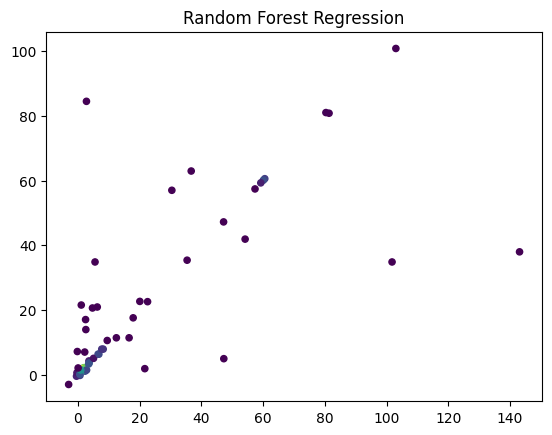

In [45]:
#%% PLOT BEST RF PERFORMANCE
#https://stackoverflow.com/questions/19064772/visualization-of-scatter-plots-with-overlapping-points-in-matplotlib
from scipy import stats

values = np.vstack([y_test.ravel(), y_pred.ravel()])
kernel = stats.gaussian_kde(values, bw_method=.02)(values)

plt.scatter(y_test, y_pred, s=20, c=kernel,cmap='viridis')
# plt.axline((0,0), (50,50), linewidth=1, color='black')
# plt.axis((0,50,0,50))
# plt.xscale('log')
# plt.yscale('log')
plt.title ('Random Forest Regression')

# plt.savefig('log_randomforest_plot.png')